In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [2]:
dataset = pd.read_csv('AAPL.csv',index_col="Date",parse_dates=True)
#dataset

In [77]:
# convert column "a" of a DataFrame
# dataset["Close"] = dataset["Close"].str.replace(',', '').astype(float)


In [78]:
# dataset["Volume"] = dataset["Volume"].str.replace(',', '').astype(float)

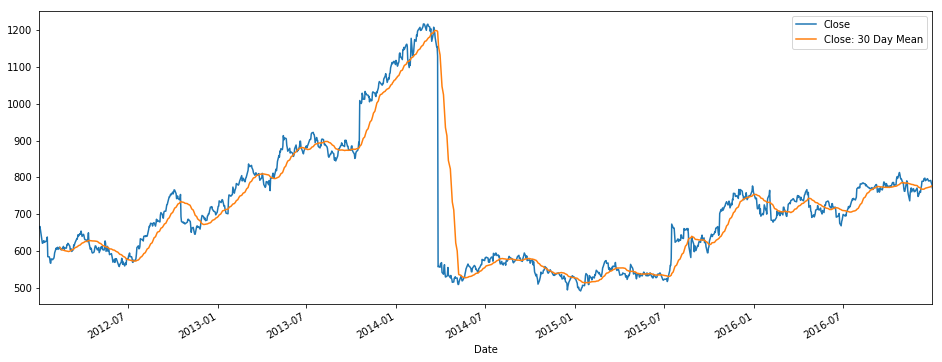

In [81]:
# dataset['Close: 30 Day Mean'] = dataset['Close'].rolling(window=30).mean()
# dataset[['Close','Close: 30 Day Mean']].plot(figsize=(16,6))

In [153]:
# for closing prices
training_set=dataset['Close']
training_set=pd.DataFrame(training_set)

start=1200 #1200
end=200 #200

training_set=training_set[-1*start:-1*end]
realvalue=training_set
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [100]:
# # For multiple inputs

# dataset.head()
# training_set = dataset[['Close','Open','MACD','RSI EWMA']]
# training_set = pd.DataFrame(training_set)

# start=2400 #1200
# end=1400 #200

# training_set=training_set[-1*start:-1*end]
# realvalue=training_set

# # Feature Scaling
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = training_set
# training_set_scaled[['Close','Open','RSI EWMA']] = sc.fit_transform(training_set[['Close','Open','RSI EWMA']])


In [162]:
# Creating a data structure with 60 timesteps and 1 output
xdata= []
ydata = []
window=30
length=training_set_scaled.shape[0]-1

training_set_scaled = np.array(training_set_scaled)

for i in range(window, length):
    xdata.append(training_set_scaled[i-window:i,:])
    ydata.append(training_set_scaled[i+1, :]) 
xdata, ydata = np.array(xdata), np.array(ydata)

per=0.9 #0.9
split=int(per*len(xdata))
X_test=xdata[split:,:]
Y_test=ydata[split:]
realvalue1=realvalue[-len(Y_test):]

X_train=xdata[:split,:]            
y_train=ydata[:split]

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

In [163]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()



In [164]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 200, return_sequences = True,activation='relu'))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 200, return_sequences =True, activation='tanh'))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 200,activation='relu'))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [165]:

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32,shuffle=True)


Epoch 1/100
872/872 [==============================] - 17s 19ms/step - loss: 0.0526
Epoch 2/100
872/872 [==============================] - 8s 9ms/step - loss: 0.0084
Epoch 3/100
872/872 [==============================] - 8s 9ms/step - loss: 0.0046
Epoch 4/100
872/872 [==============================] - 9s 11ms/step - loss: 0.0040
Epoch 5/100
872/872 [==============================] - 9s 10ms/step - loss: 0.0039
Epoch 6/100
872/872 [==============================] - 10s 12ms/step - loss: 0.0038
Epoch 7/100
872/872 [==============================] - 9s 10ms/step - loss: 0.0037
Epoch 8/100
872/872 [==============================] - 9s 11ms/step - loss: 0.0032
Epoch 9/100
872/872 [==============================] - 9s 10ms/step - loss: 0.0032
Epoch 10/100
872/872 [==============================] - 10s 11ms/step - loss: 0.0032
Epoch 11/100
872/872 [==============================] - 9s 11ms/step - loss: 0.0031
Epoch 12/100
872/872 [==============================] - 9s 11ms/step - loss: 0.0027


872/872 [==============================] - 10s 12ms/step - loss: 0.0015
Epoch 99/100
872/872 [==============================] - 9s 11ms/step - loss: 0.0014
Epoch 100/100
872/872 [==============================] - 9s 10ms/step - loss: 0.0013


In [166]:
xt=X_test
xt = np.reshape(xt, (xt.shape[0], xt.shape[1], xt.shape[2]))
predicted_stock_price = regressor.predict(xt)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [167]:
pp=pd.DataFrame(predicted_stock_price)
pp1=pp.shift(-1)
prediction=np.where(pp<pp1,1,-1)

real=pd.DataFrame(realvalue1)
real1=real.shift(-1)
real1=np.where(real<real1,1,-1)

from sklearn.metrics import accuracy_score
score=accuracy_score(real1, prediction)
score

0.5463917525773195

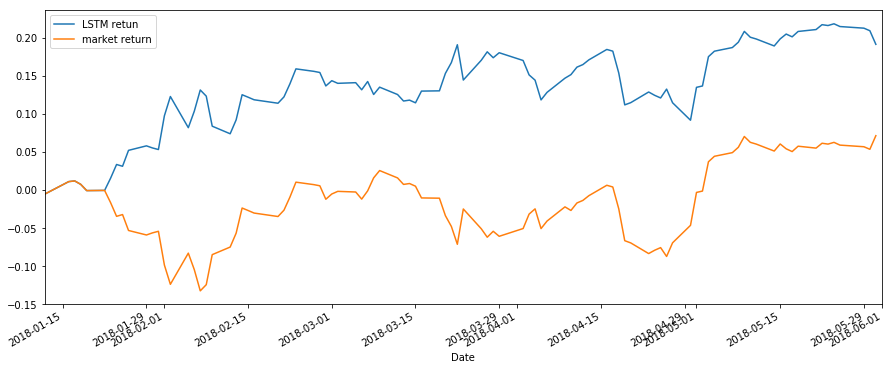

In [171]:
pp = np.array(pp)

data=real
data['pp']=pp

data['ret1']=np.log(data.Close/data.Close.shift(1))# calculating the every day return
data['ret1']=real['ret1'].shift(-1) # bringing the return to the previous day
data['p_sig']=prediction # prediction signal
data['v_p']=data.p_sig*real.ret1 #value prediction retun

# Plot the cumulative returns for single leaf in train dataset
data.v_p.cumsum().plot(figsize=(15,6))

# Plot the cumulative returns for full tree in train dataset
data.ret1.cumsum().plot(figsize=(15,6))
plt.legend(["LSTM retun", "market return"]);


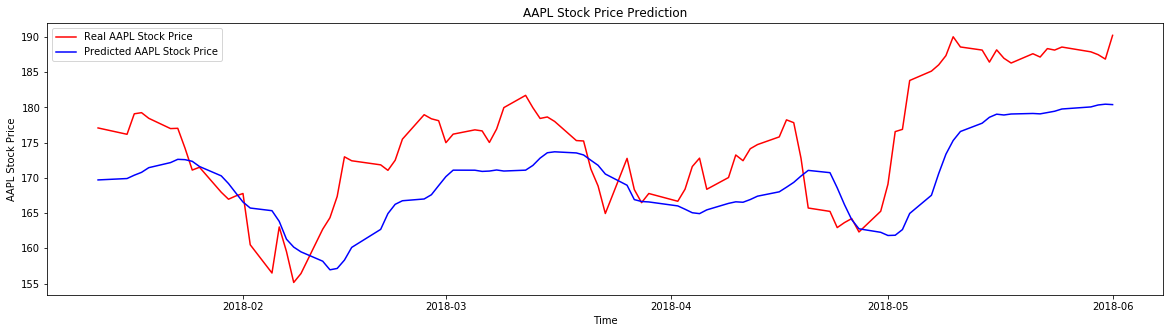

In [170]:
plt.figure(figsize=(20,5))
plt.plot(data['Close'], color = 'red', label = 'Real AAPL Stock Price')
plt.plot(data['pp'], color = 'blue', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
#for i in j:
#    plt.axvline(x=i)
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()